Goal: Build a classification model to predict which country is likely to receive refugees based on factors like GDP and country of origin.


## Libraries and settings

In [4]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

# Show version of scikit-learn
import sklearn
sklearn.__version__

c:\DataAnalytics\DataAnalyticsLN\Classification as Modelling Method


'1.6.0'

## Import data

In [5]:
#Read and select variables
df_refugees_orig = pd.read_csv("refugee_data_and_gdp.csv",sep=',',encoding="utf-8")

#Number of rows and columns
print(df_refugees_orig.shape)

#first 5 rows
df_refugees_orig.head(100)

(2160, 7)


,year,country_name,gdp,total_refugees,coo_name,total,male_female_ratio
0,2001,France,1.370377e+12,6036.0,Afghanistan,1284.0,1.221453
1,2001,France,1.370377e+12,6036.0,Syrian Arab Rep.,192.0,2.918367
2,2001,France,1.370377e+12,6036.0,Iran (Islamic Rep. of),1987.0,1.806497
3,2001,France,1.370377e+12,6036.0,Iraq,1629.0,1.291139
4,2001,France,1.370377e+12,6036.0,Ukraine,407.0,1.014851
...,...,...,...,...,...,...,...
95,2002,France,1.492428e+12,5947.0,Nigeria,181.0,2.232143
96,2002,Germany,2.102351e+12,277159.0,Afghanistan,64363.0,NaN
97,2002,Germany,2.102351e+12,277159.0,Syrian Arab Rep.,15677.0,NaN
98,2002,Germany,2.102351e+12,277159.0,Iran (Islamic Rep. of),54000.0,NaN


### Variable description

### Count and remove missing values

In [6]:
# Count missing values
print(df_refugees_orig.isna().sum())
#remove rows with missing values
df_refugees_orig = df_refugees_orig.dropna()


year                    0
country_name            0
gdp                     0
total_refugees          0
coo_name               46
total                  46
male_female_ratio    1277
dtype: int64


Regression RMSE: 604432.2088504488
Regression R-squared: -0.12269899374183191


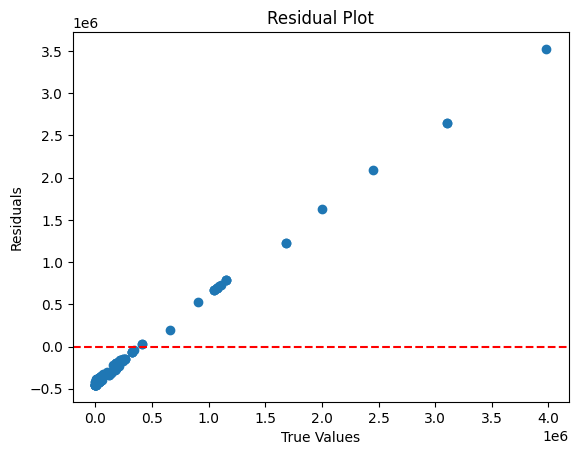

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Features and target for regression
X_reg = df_refugees_orig[['gdp']]  # Use 'gdp' as the feature
y_reg = df_refugees_orig['total_refugees']  # Predict 'total_refugees'

# Split data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train the regression model
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = reg_model.predict(X_test_reg)

# Evaluate the regression model
mse = mean_squared_error(y_test_reg, y_pred_reg)  # Mean Squared Error
rmse = mse ** 0.5  # Root Mean Squared Error
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Regression RMSE: {rmse}")
print(f"Regression R-squared: {r2}")

# Residual plot
plt.scatter(y_test_reg, y_test_reg - y_pred_reg)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()



### Transform nominal variable to matrix with 0/1 values

In [109]:
# Step 1: Perform one-hot encoding for multiple nominal variables
coo_encoded = pd.get_dummies(df_refugees_orig['coo_name'], prefix='coo')
country_encoded = pd.get_dummies(df_refugees_orig['country_name'], prefix='country')

# Step 2: Concatenate the one-hot encoded columns with the original dataframe
df_encoded = pd.concat([df_refugees_orig, coo_encoded, country_encoded], axis=1)

# Optional: Drop the original nominal columns if no longer needed
# df_encoded = df_encoded.drop(columns=['coo_name', 'country_name'])

# Display the transformed dataframe
df_encoded.head()

,year,country_name,gdp,total_refugees,coo_name,total,male_female_ratio,coo_Afghanistan,coo_Iran (Islamic Rep. of),coo_Iraq,...,country_Germany,country_Greece,country_Italy,country_Portugal,country_Spain,country_Sweden,country_Switzerland,country_Türkiye,country_United Kingdom of Great Britain and Northern Ireland,country_United States of America
0,2001,France,1.370377e+12,6036.0,Afghanistan,1284.0,1.221453,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2001,France,1.370377e+12,6036.0,Syrian Arab Rep.,192.0,2.918367,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2001,France,1.370377e+12,6036.0,Iran (Islamic Rep. of),1987.0,1.806497,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2001,France,1.370377e+12,6036.0,Iraq,1629.0,1.291139,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2001,France,1.370377e+12,6036.0,Ukraine,407.0,1.014851,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Combine one hot encoding of country_name into single column

In [110]:
#rename country_name to c_name
df_encoded = df_encoded.rename(columns={'country_name': 'c_name'})

# Step 1: Identify the one-hot encoded columns
country_columns = [col for col in df_encoded.columns if col.startswith('country_')]

# Step 2: Combine one-hot encoded columns into a single binary string column
df_encoded['country_binary'] = df_encoded[country_columns].astype(int).astype(str).agg(''.join, axis=1)

# Step 3: Display the updated dataframe
df_encoded.head()

,year,c_name,gdp,total_refugees,coo_name,total,male_female_ratio,coo_Afghanistan,coo_Iran (Islamic Rep. of),coo_Iraq,...,country_Greece,country_Italy,country_Portugal,country_Spain,country_Sweden,country_Switzerland,country_Türkiye,country_United Kingdom of Great Britain and Northern Ireland,country_United States of America,country_binary
0,2001,France,1.370377e+12,6036.0,Afghanistan,1284.0,1.221453,True,False,False,...,False,False,False,False,False,False,False,False,False,10000000000
1,2001,France,1.370377e+12,6036.0,Syrian Arab Rep.,192.0,2.918367,False,False,False,...,False,False,False,False,False,False,False,False,False,10000000000
2,2001,France,1.370377e+12,6036.0,Iran (Islamic Rep. of),1987.0,1.806497,False,True,False,...,False,False,False,False,False,False,False,False,False,10000000000
3,2001,France,1.370377e+12,6036.0,Iraq,1629.0,1.291139,False,False,True,...,False,False,False,False,False,False,False,False,False,10000000000
4,2001,France,1.370377e+12,6036.0,Ukraine,407.0,1.014851,False,False,False,...,False,False,False,False,False,False,False,False,False,10000000000


#### combine one hot encoding of coo_name into single column

In [111]:
#rename coo_name to Origin_name
df_encoded = df_encoded.rename(columns={'coo_name': 'origin_name'})

# Step 1: Identify the one-hot encoded columns
Origin_columns = [col for col in df_encoded.columns if col.startswith('coo_')]
# Step 2: Combine one-hot encoded columns into a single binary string column
df_encoded['origin_binary'] = df_encoded[Origin_columns].astype(int).astype(str).agg(''.join, axis=1)

# Step 3: Display the updated dataframe
df_encoded.head(35)

,year,c_name,gdp,total_refugees,origin_name,total,male_female_ratio,coo_Afghanistan,coo_Iran (Islamic Rep. of),coo_Iraq,...,country_Italy,country_Portugal,country_Spain,country_Sweden,country_Switzerland,country_Türkiye,country_United Kingdom of Great Britain and Northern Ireland,country_United States of America,country_binary,origin_binary
0,2001,France,1.370377e+12,6036.0,Afghanistan,1284.0,1.221453,True,False,False,...,False,False,False,False,False,False,False,False,10000000000,100000000
1,2001,France,1.370377e+12,6036.0,Syrian Arab Rep.,192.0,2.918367,False,False,False,...,False,False,False,False,False,False,False,False,10000000000,000000010
2,2001,France,1.370377e+12,6036.0,Iran (Islamic Rep. of),1987.0,1.806497,False,True,False,...,False,False,False,False,False,False,False,False,10000000000,010000000
3,2001,France,1.370377e+12,6036.0,Iraq,1629.0,1.291139,False,False,True,...,False,False,False,False,False,False,False,False,10000000000,001000000
4,2001,France,1.370377e+12,6036.0,Ukraine,407.0,1.014851,False,False,False,...,False,False,False,False,False,False,False,False,10000000000,000000001
5,2001,France,1.370377e+12,6036.0,Palestinian,78.0,2.250000,False,False,False,...,False,False,False,False,False,False,False,False,10000000000,000000100
6,2001,France,1.370377e+12,6036.0,Pakistan,145.0,2.918919,False,False,False,...,False,False,False,False,False,False,False,False,10000000000,000001000
7,2001,France,1.370377e+12,6036.0,Liberia,151.0,1.960784,False,False,False,...,False,False,False,False,False,False,False,False,10000000000,000100000
8,2001,France,1.370377e+12,6036.0,Nigeria,163.0,2.326531,False,False,False,...,False,False,False,False,False,False,False,False,10000000000,000010000
55,2001,Switzerland,2.865827e+11,8830.0,Afghanistan,2175.0,1.507585,True,False,False,...,False,False,False,False,True,False,False,False,00000001000,100000000


#### Define X and Y

In [112]:
# Select features and encode nominal variables
features = ['gdp', 'total_refugees', 'male_female_ratio'] + \
           ['origin_binary'] 

# Define predictors (X) and target variable (y)
X = df_encoded[features]
y = df_encoded['country_binary']
y = pd.Categorical(y).codes



In [113]:
# Check the type and dtype
print(type(y))  # Should show <class 'numpy.ndarray'>
print(y.dtype)  # Should show the data type, e.g., int64



<class 'numpy.ndarray'>
int8


## Classification Tree

### Create train and test samples (train 80%, test 20% of the data)

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Fit the classification tree model and make predictions

In [115]:
# Initialize the classification tree model 
clf = DecisionTreeClassifier(random_state=20, 
                             max_depth=7)

# Train the classification tree model 
clf = clf.fit(X_train, y_train)

# Make model predictions
y_pred = clf.predict(X_test)
y_pred

array([ 3,  3,  3,  3,  1,  5,  2, 10, 10,  8,  3, 10, 10, 10,  9,  9,  9,
        6, 10,  9,  2,  5,  3,  7, 10,  9,  3,  8,  8, 10,  8,  2,  3,  4,
        2,  4,  2,  4,  4,  7, 10,  9,  9,  9,  3,  3,  3,  3, 10,  9,  3,
        3, 10, 10,  2,  9,  4,  8,  2, 10,  9,  5,  3,  2, 10,  2,  1, 10,
       10,  3,  8,  2,  9,  5,  8,  7,  5,  2,  5, 10,  7, 10,  3,  8,  8,
        3, 10,  6,  7, 10,  0,  3, 10,  5,  3, 10,  3,  9,  9,  8,  2, 10,
        2,  2,  3,  2,  3,  2, 10,  3, 10,  1,  1,  3,  3,  2,  1,  9,  3,
        7,  4,  3,  2,  6,  5,  3,  8,  9,  4,  2, 10,  5,  9,  2,  8,  3,
       10,  9,  2,  3,  9,  7,  1, 10,  2,  3, 10,  8,  9,  2,  9, 10,  1,
        9,  2,  2,  3,  9, 10,  9,  9, 10, 10,  2,  2,  3,  6, 10,  2,  3,
        4,  3, 10,  3,  3, 10,  3], dtype=int8)

### Show confusion matrix and classification report

In [116]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred), '\n')

# Classification report
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[ 0  2  0  0  0  0  0  0  0  0  0]
 [ 1  5  0  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0]
 [ 0  0  0 39  0  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 36]] 

Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      0.83      0.77         6
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        39
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00        13
           9       1.

### Print text representation of the classification tree

In [117]:
# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)

|--- gdp <= 1087362138112.00
|   |--- gdp <= 277828042752.00
|   |   |--- gdp <= 75126898688.00
|   |   |   |--- total_refugees <= 2386.50
|   |   |   |   |--- male_female_ratio <= 1.21
|   |   |   |   |   |--- origin_binary <= 5000.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- origin_binary >  5000.50
|   |   |   |   |   |   |--- male_female_ratio <= 0.78
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- male_female_ratio >  0.78
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- male_female_ratio >  1.21
|   |   |   |   |   |--- male_female_ratio <= 3.94
|   |   |   |   |   |   |--- origin_binary <= 5500000.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- origin_binary >  5500000.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- male_female_ratio >  3.94
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- total_refugees >  2386.50
|   |   |   |   |--- class: 2
|   |   |--- gdp >  7512

### Visualize the classification tree

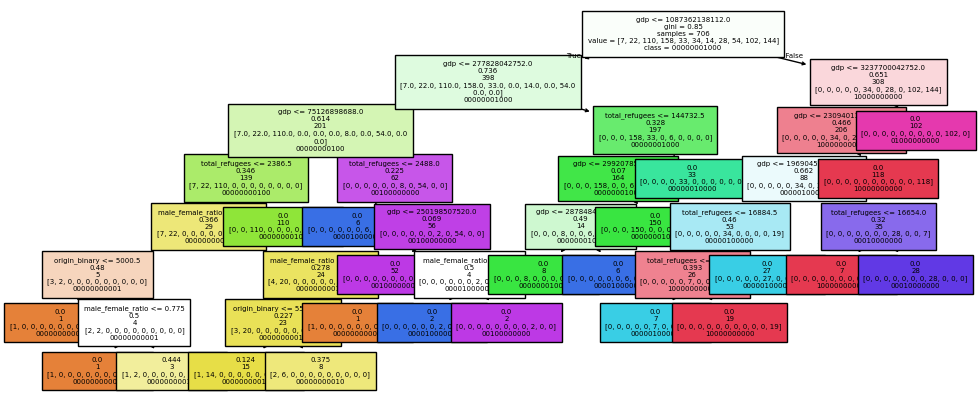

In [118]:
# For the meaning of numbers in boxes see root node
fig = plt.figure(figsize=(12,5))

# Plot the classification tree
tree_plot = tree.plot_tree(clf, 
                   feature_names=list(X_train.columns),  
                   class_names=pd.Categorical(df_encoded['country_binary']).categories ,
                   filled=True,
                   fontsize=5,
                   label='root')

## Random Forest Classifier

### Create train and test samples (train 80%, test 20% of the data)

In [119]:
# Create train and test samples
X2_train, X2_test, y2_train, y2_test = train_test_split(
    df_encoded[['gdp', 'total_refugees', 'male_female_ratio'] + \
           ['origin_binary']],
    df_encoded['country_binary'],
    test_size=0.20,
    random_state=42
)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())


X2_train:
               gdp  total_refugees  male_female_ratio origin_binary
1762  0.000000e+00             0.0           2.622419     000000010
1364  6.941182e+11         34112.0           1.062642     010000000
1119  3.808086e+12        158908.0           3.228571     000100000
1114  3.808086e+12        158908.0           1.629204     010000000
284   2.349796e+11          7945.0           6.241379     010000000 

y2_train:
1762    00000000010
1364    00000001000
1119    01000000000
1114    01000000000
284     00100000000
Name: country_binary, dtype: object


### Fit the Random Forest Classifier

In [120]:
# Initialize the random forest classifier
rfc = RandomForestClassifier(random_state=20, max_depth=10)

# Train the random forest classifier
rfc = rfc.fit(X2_train, y2_train)

# Predict the target variable (country_binary))
y_pred_rf = rfc.predict(X2_test)

print('Predicted target variable (country_binary)')
y_pred_rf

Predicted target variable (country_binary)


array(['00000001000', '10000000000', '00000001000', '00000001000',
       '00000000010', '00000100000', '00000001000', '00000001000',
       '00000001000', '00000000100', '00000000100', '00000001000',
       '01000000000', '10000000000', '00000001000', '00010000000',
       '10000000000', '00000001000', '01000000000', '00000010000',
       '00000001000', '00000001000', '00000000010', '00000100000',
       '00000001000', '10000000000', '01000000000', '00000000100',
       '00000100000', '10000000000', '10000000000', '01000000000',
       '10000000000', '00000001000', '00000000100', '00000001000',
       '00000010000', '00000001000', '00000100000', '01000000000',
       '01000000000', '00000000100', '00100000000', '00000100000',
       '00000001000', '10000000000', '00100000000', '00000001000',
       '00010000000', '00000001000', '00000001000', '01000000000',
       '01000000000', '00000010000', '00000000100', '00000001000',
       '00000001000', '00100000000', '00100000000', '000000010

### Show confusion matrix and classification report

In [121]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y2_test, y_pred_rf), '\n')

# Classification report
print('Classification report')
print(classification_report(y2_test, y_pred_rf))

Confusion matrix
[[ 0  3  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0 52  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0  0 29]] 

Classification report
              precision    recall  f1-score   support

 00000000001       0.00      0.00      0.00         3
 00000000010       0.57      1.00      0.73         4
 00000000100       1.00      1.00      1.00        17
 00000001000       1.00      1.00      1.00        52
 00000010000       1.00      1.00      1.00         6
 00000100000       1.00      1.00      1.00         8
 00001000000       1.00      1.00      1.00         2
 00010000000       1.00      1.00      1.00         8
 00100000000       1.00      1.00      1.00        18
 01000000000       1.

### Show feature importance

Index(['gdp', 'total_refugees', 'male_female_ratio', 'origin_binary'], dtype='object')
[0.61153441 0.3160313  0.05788995 0.01454434]


<Axes: ylabel='features'>

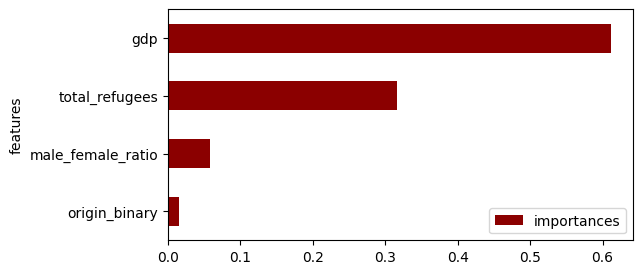

In [122]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

### ROC curve and AUC - Das stimmt sowas vo need

since we multiple categories (not binary), we will make a multi class AUC

In [124]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities
y_proba = clf.predict_proba(X_test)

# Calculate macro AUC
macro_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"Macro-Averaged AUC: {macro_auc:.2f}")


Macro-Averaged AUC: 0.99


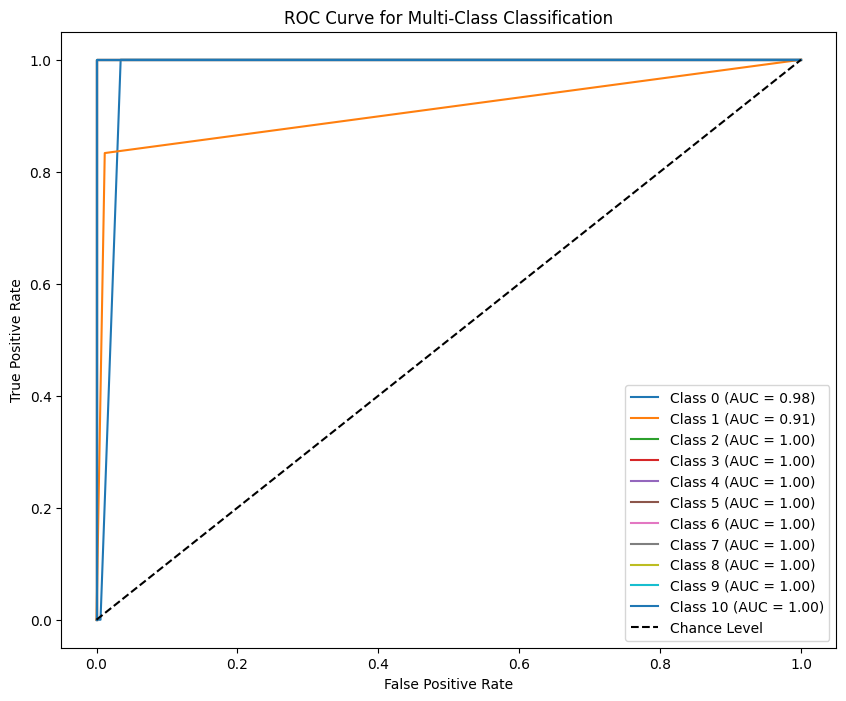

In [125]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(clf.classes_):
    y_binary = (y_test == class_label).astype(int)
    y_score = clf.predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()